In [1]:
'''更新日志16July
这一版是分类模型
加了模型评价：ROC
'''

'更新日志16July\n这一版是分类模型\n加了模型评价：ROC\n'

In [2]:
'''
单通道3D卷积神经网络，使用体素模型。相比点云方法，优点是能够直接进行3D卷积运算，缺点是数据量和算量都更大。
输入：预备体的体素模型
网络结构：3D卷积-池化-3D卷积-池化-扁平化-MLP-输出
'''

'\n单通道3D卷积神经网络，使用体素模型。相比点云方法，优点是能够直接进行3D卷积运算，缺点是数据量和算量都更大。\n输入：预备体的体素模型\n网络结构：3D卷积-池化-3D卷积-池化-扁平化-MLP-输出\n'

In [3]:
'''
# 安装环境
pip install trimesh
'''

'\n# 安装环境\npip install trimesh\n'

In [4]:
'''
# 安装环境
pip install torch torchvision torchaudio
'''

'\n# 安装环境\npip install torch torchvision torchaudio\n'

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import trimesh

In [6]:
# 加载和归一化模型
def load_mesh(file_path):
    mesh = trimesh.load(file_path)
    # 如果加载的是Scene对象，转换为Trimesh对象
    if isinstance(mesh, trimesh.Scene):
        mesh = mesh.dump(concatenate=True)
    return mesh

def normalize_mesh(mesh):
    # 将网格中心平移到原点
    mesh.apply_translation(-mesh.centroid)
    # 计算缩放比例
    scale_factor = 1.0 / max(mesh.extents)
    # 缩放网格
    mesh.apply_scale(scale_factor)
    return mesh

def mesh_to_voxel(mesh, voxel_size=32):
    # 将网格体素化
    voxelized_mesh = mesh.voxelized(pitch=1.0 / voxel_size)
    # 确保体素矩阵的形状为 (voxel_size, voxel_size, voxel_size)
    voxel_matrix = voxelized_mesh.matrix
    padded_matrix = np.zeros((voxel_size, voxel_size, voxel_size), dtype=voxel_matrix.dtype)
    shape = np.minimum(voxel_matrix.shape, (voxel_size, voxel_size, voxel_size))
    padded_matrix[:shape[0], :shape[1], :shape[2]] = voxel_matrix[:shape[0], :shape[1], :shape[2]]
    return padded_matrix

# 读取评分
def read_scores(score_file_path):
    indices = []
    scores = []
    with open(score_file_path, 'r') as f:
        for line in f:
            index, score = line.strip().split()
            indices.append(int(index))
            scores.append(int(score)-1)  # 离散化，-1，取值区间[0,4]
    return indices, scores  



In [7]:
# 定义数据集
class TeethDataset(Dataset):
    def __init__(self, score_file_path, voxel_size=32):
        self.indices, self.scores = read_scores(score_file_path)
        self.voxel_size = voxel_size

    def __len__(self):
        return len(self.scores)

    def __getitem__(self, idx):
        index = self.indices[idx]
        score = self.scores[idx]
        mesh_path = f'{index}.obj'
        mesh = normalize_mesh(load_mesh(mesh_path))
        voxel_data = mesh_to_voxel(mesh, self.voxel_size)
        return torch.tensor(voxel_data[np.newaxis, :], dtype=torch.float32), torch.tensor(score, dtype=torch.long)  # 确保 score 是 long 类型

# 创建数据集
score_file_path = 'grades.txt'
dataset = TeethDataset(score_file_path, voxel_size=32)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True) 


In [8]:
# 定义模型
class Teeth3DCNN(nn.Module):
    def __init__(self):
        super(Teeth3DCNN, self).__init__()
        self.conv1 = nn.Conv3d(1, 32, kernel_size=3, stride=1, padding=1)  # 单通道输入
        self.conv2 = nn.Conv3d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8 * 8, 256)  # 体素尺寸为32*32*32，经过两次pooling变为8*8*8
        self.fc2 = nn.Linear(256, 5)  # 输出5个类别
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x    

# 创建模型
model = Teeth3DCNN()
criterion = nn.CrossEntropyLoss()  # 损失函数
optimizer = optim.Adam(model.parameters(), lr=0.001)  # 学习率和优化器

In [10]:
# 训练模型
num_epochs = 25
all_targets = []
all_predictions = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        # 记录targets、predictions用于模型评估
        all_targets.extend(targets.numpy())
        all_predictions.extend(outputs.detach().numpy())
        
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader)}")

# 改成 numpy arrays
all_targets = np.array(all_targets)
all_predictions = np.array(all_predictions)


Epoch 1/25, Loss: 1.566609407726087
Epoch 2/25, Loss: 1.532962701822582
Epoch 3/25, Loss: 1.5209131021248667
Epoch 4/25, Loss: 1.4587287557752509
Epoch 5/25, Loss: 1.4755698222863047
Epoch 6/25, Loss: 1.4743926462374235
Epoch 7/25, Loss: 1.4474973835443194
Epoch 8/25, Loss: 1.4342998046624034
Epoch 9/25, Loss: 1.380432227724477
Epoch 10/25, Loss: 1.334380534134413
Epoch 11/25, Loss: 1.260840163419121
Epoch 12/25, Loss: 1.2170660574185221
Epoch 13/25, Loss: 1.162249571398685
Epoch 14/25, Loss: 1.0959169033326601
Epoch 15/25, Loss: 1.0757522614378678
Epoch 16/25, Loss: 0.9964386428657331
Epoch 17/25, Loss: 0.9439892094386252
Epoch 18/25, Loss: 0.8956771265519293
Epoch 19/25, Loss: 0.7494406864831322
Epoch 20/25, Loss: 0.8351293876767159
Epoch 21/25, Loss: 0.6058564923311535
Epoch 22/25, Loss: 0.5784682639335331
Epoch 23/25, Loss: 0.47137776174043355
Epoch 24/25, Loss: 0.38045094750429453
Epoch 25/25, Loss: 0.36612665555194807


In [12]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt

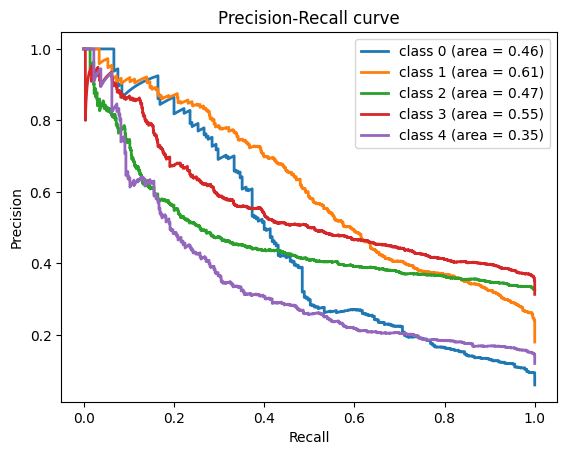

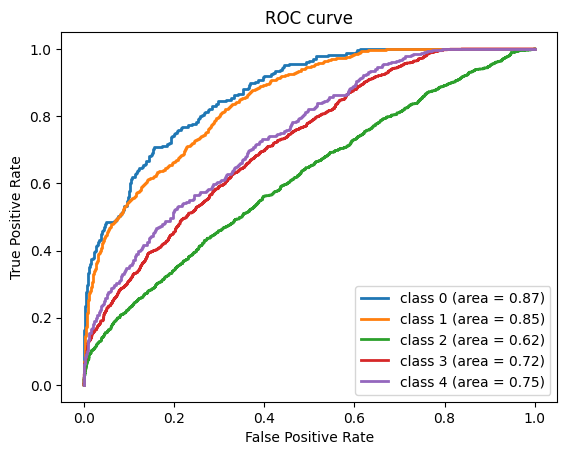

In [13]:
# 计算 Precision-Recall
precision = {}
recall = {}
pr_auc = {}
for i in range(5):
    precision[i], recall[i], _ = precision_recall_curve(all_targets == i, all_predictions[:, i])
    pr_auc[i] = auc(recall[i], precision[i])

# 绘制 Precision-Recall 曲线
plt.figure()
for i in range(5):
    plt.plot(recall[i], precision[i], lw=2, label=f'class {i} (area = {pr_auc[i]:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='best')
plt.show()

# 计算 ROC
fpr = {}
tpr = {}
roc_auc = {}
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(all_targets == i, all_predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 绘制 ROC 曲线
plt.figure()
for i in range(5):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'class {i} (area = {roc_auc[i]:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
'''
# 对150个预备体进行评分
model.eval()
scores = []
with torch.no_grad():
    for i in range(len(dataset)):
        inputs, _ = dataset[i]  # 忽略目标评分，只取输入数据
        inputs = inputs.unsqueeze(0)  # 添加批次维度
        output = model(inputs)
        predicted_class = torch.argmax(output, dim=1).item() + 1
        scores.append(predicted_class)

# 输出150个预备体的评分
for i, score in enumerate(scores):
    print(f'Tooth {i+1}: Score = {score}')
'''